In [12]:
import pandas as pd
import numpy as np
import os
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from scipy import stats


In [13]:
def load_csv(file_name):
    df=pd.read_csv(file_name)
    return df
file_name='../Data/combined_with_classification_2.csv'
fashion_df=load_csv(file_name)
copy=fashion_df.copy()

In [14]:
copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13847 entries, 0 to 13846
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SKU              13847 non-null  object 
 1   Reviews Num      13847 non-null  int64  
 2   1 Star Reviews   13847 non-null  int64  
 3   1 Star Images    13847 non-null  int64  
 4   2 Stars Reviews  13847 non-null  int64  
 5   2 Stars Images   13847 non-null  int64  
 6   3 Stars Reviews  13847 non-null  int64  
 7   3 Stars Images   13847 non-null  int64  
 8   4 Stars Reviews  13847 non-null  int64  
 9   4 Stars Images   13847 non-null  int64  
 10  5 Stars Reviews  13847 non-null  int64  
 11  5 Stars Images   13847 non-null  int64  
 12  Points Earnning  13847 non-null  int64  
 13  Style            13847 non-null  object 
 14  Color            13847 non-null  object 
 15  Pattern Type     13847 non-null  object 
 16  Length           13847 non-null  object 
 17  Type        

In [15]:
review_cols = ["1 Star Reviews","2 Stars Reviews","3 Stars Reviews","4 Stars Reviews","5 Stars Reviews"]
image_cols  = ["1 Star Images","2 Stars Images","3 Stars Images","4 Stars Images","5 Stars Images"]

# 0) Force numeric for star counts
copy[review_cols + image_cols] = copy[review_cols + image_cols].apply(pd.to_numeric, errors="coerce")

# 1) Totals
copy["num_review_ratings"] = copy[review_cols].sum(axis=1, min_count=1)
copy["num_image_ratings"]  = copy[image_cols].sum(axis=1,  min_count=1)
copy["Total Ratings"] = copy["num_review_ratings"].fillna(0) + copy["num_image_ratings"].fillna(0)

# 2) Weighted sums
w = np.array([1,2,3,4,5], dtype=float)
rev_w = copy[review_cols].multiply(w, axis=1).sum(axis=1, min_count=1)
img_w = copy[image_cols].multiply(w, axis=1).sum(axis=1, min_count=1)

# 3) Safe averages (NaN if denominator==0 or all-NaN)
copy["Avg Review Score"] = rev_w / copy["num_review_ratings"]
copy["Avg Image Score"]  = img_w / copy["num_image_ratings"]

# 4) Combine smartly: if one side NaN, take the other; if both NaN -> stays NaN
copy["Combined Avg Score"] = np.where(
    copy["Avg Review Score"].notna() & copy["Avg Image Score"].notna(),
    (copy["Avg Review Score"] + copy["Avg Image Score"]) / 2.0,
    copy["Avg Review Score"].where(copy["Avg Review Score"].notna(), copy["Avg Image Score"])
)

# 5) Keep only rows with at least 1 rating and defined combined score
mask_use = (copy["Total Ratings"] > 0) & (copy["Combined Avg Score"].notna())
copy = copy[mask_use].copy()

# 6) Weighted Combined Score
copy["Weighted Combined Score"] = copy["Combined Avg Score"] * np.log1p(copy["Total Ratings"])

# 7) Target (e.g., median cutoff)
cutoff = copy["Weighted Combined Score"].median()
copy["Classification"] = (copy["Weighted Combined Score"] >= cutoff).astype(int)


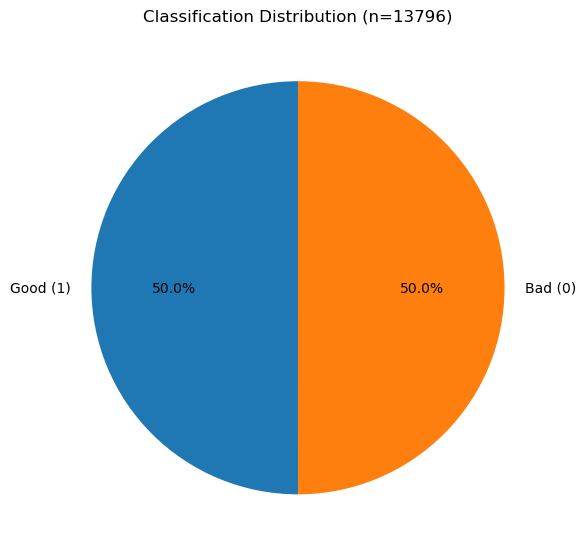

Counts: {1: 6899, 0: 6897}
Proportions: {1: 0.5, 0: 0.5}


In [16]:
# Pie chart of class distribution
counts = copy["Classification"].value_counts().reindex([1, 0], fill_value=0)
labels = ["Good (1)", "Bad (0)"]

plt.figure(figsize=(6,6))
counts.plot(
    kind="pie",
    labels=labels,
    autopct="%1.1f%%",
    startangle=90
)
plt.title(f"Classification Distribution (n={int(counts.sum())})")
plt.ylabel("")        # cleaner look
plt.gca().set_aspect("equal")  # make it a circle
plt.tight_layout()
plt.show()

# Optional: also print exact counts and proportions
print("Counts:", counts.to_dict())
print("Proportions:", (counts / counts.sum()).round(3).to_dict())


In [17]:
#deleate the columns that we used to calculate the lable
col_list=['Avg Review Score','Avg Image Score','Combined Avg Score','1 Star Images','2 Stars Images','3 Stars Images','4 Stars Images','5 Stars Images','Reviews Num','1 Star Reviews','2 Stars Reviews','3 Stars Reviews','4 Stars Reviews','5 Stars Reviews']
copy.drop(axis=1, index=None, columns=col_list, inplace=True)


In [18]:
copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13796 entries, 0 to 13846
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SKU                      13796 non-null  object 
 1   Points Earnning          13796 non-null  int64  
 2   Style                    13796 non-null  object 
 3   Color                    13796 non-null  object 
 4   Pattern Type             13796 non-null  object 
 5   Length                   13796 non-null  object 
 6   Type                     13796 non-null  object 
 7   Neckline                 13796 non-null  object 
 8   Sleeve Length            13796 non-null  object 
 9   Sleeve Type              13796 non-null  object 
 10  Placket Type             13796 non-null  object 
 11  Season                   13796 non-null  object 
 12  Material                 13796 non-null  object 
 13  Fabric                   13796 non-null  object 
 14  Sheer                    13

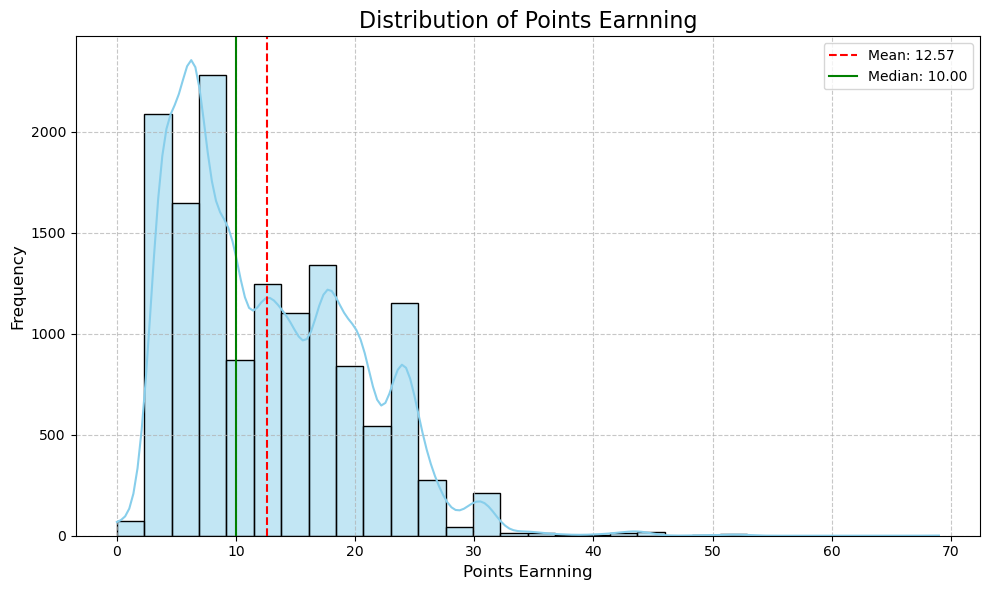

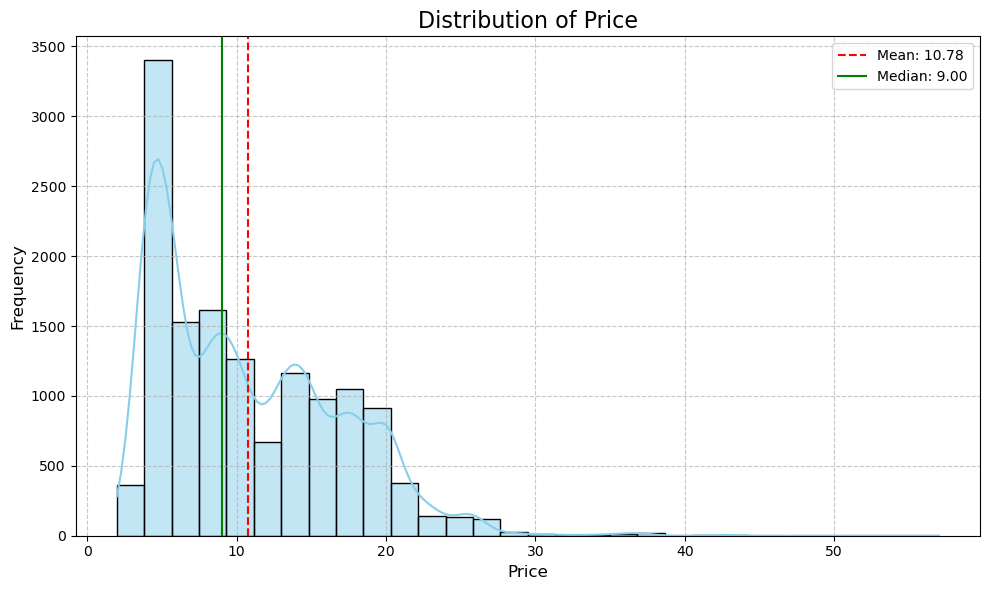

In [19]:

def plot_numeric_distributions(dataframe, numeric_cols):
    for col in numeric_cols:
        plt.figure(figsize=(10, 6))
        sns.histplot(dataframe[col], kde=True, bins=30, color='skyblue', edgecolor='black')
        plt.axvline(dataframe[col].mean(), color='red', linestyle='--', label=f"Mean: {dataframe[col].mean():.2f}")
        plt.axvline(dataframe[col].median(), color='green', linestyle='-', label=f"Median: {dataframe[col].median():.2f}")
        plt.title(f'Distribution of {col}', fontsize=16)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
plot_numeric_distributions(copy, ['Points Earnning', 'Price'])


Numeric: ['Points Earnning', 'Price', 'num_review_ratings', 'num_image_ratings', 'Total Ratings', 'Weighted Combined Score']
Categorical: ['SKU', 'Style', 'Color', 'Pattern Type', 'Length', 'Type', 'Neckline', 'Sleeve Length', 'Sleeve Type', 'Placket Type', 'Season', 'Material', 'Fabric', 'Sheer', 'Fit Type', 'Closure Type', 'Waist Line', 'Body', 'Bottom Type', 'Item Name', 'Placket', 'Belt', 'Hem Shaped', 'Top Type']
Target: Classification


/var/folders/qj/77pnkn5x019dx4qqgczd9npw0000gn/T/ipykernel_51542/756386550.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(vc.index.astype(str), rotation=45, ha='right')
/var/folders/qj/77pnkn5x019dx4qqgczd9npw0000gn/T/ipykernel_51542/756386550.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(vc.index.astype(str), rotation=45, ha='right')
/var/folders/qj/77pnkn5x019dx4qqgczd9npw0000gn/T/ipykernel_51542/756386550.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(vc.index.astype(str), rotation=45, ha='right')
/var/folders/qj/77pnkn5x019dx4qqgczd9npw0000gn/T/ipykernel_51542/756386550.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(vc.index.astype(str), rotation=45, ha='right')


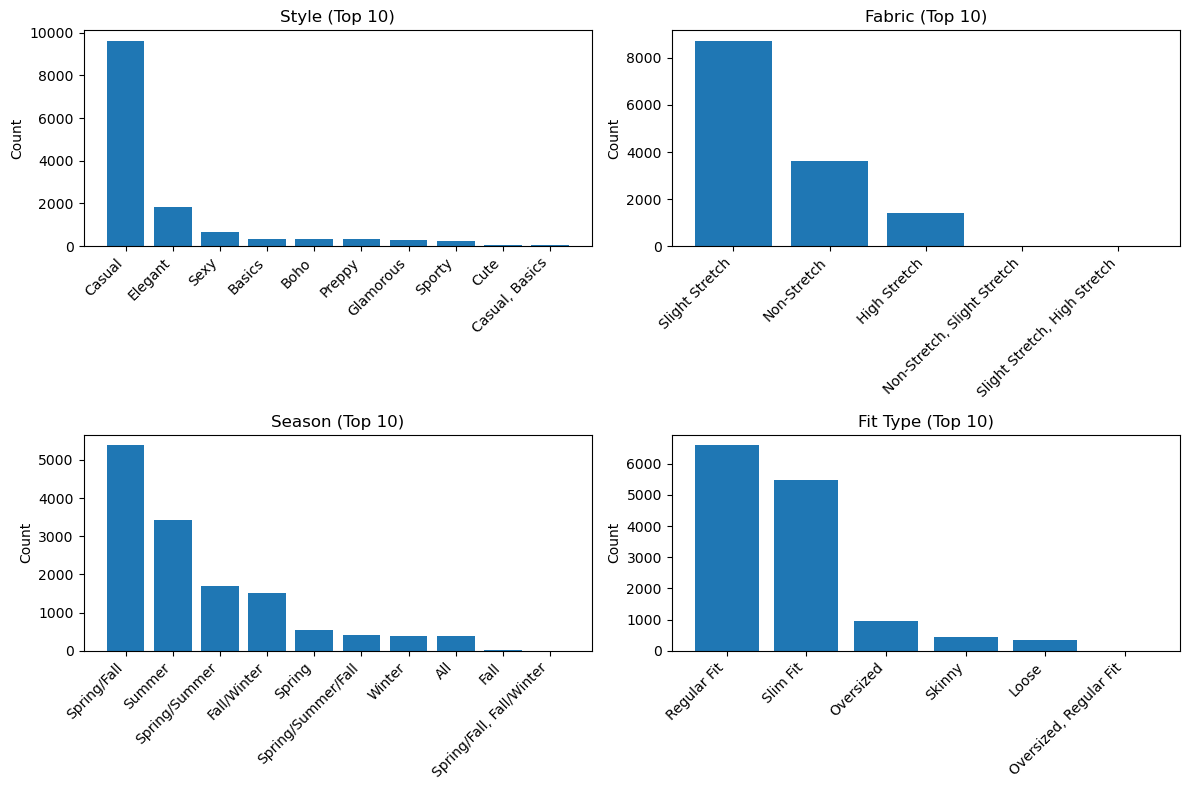

In [20]:
df = copy.copy()

num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != 'Classification']
cat_cols = list(df.select_dtypes(include=['object', 'category']).columns)

print("Numeric:", num_cols)
print("Categorical:", cat_cols)
print("Target:", 'Classification')

cols_to_plot = ['Style', 'Fabric', 'Season', 'Fit Type']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    if col in cat_cols:
        vc = df[col].value_counts().head(10)
        axes[i].bar(vc.index.astype(str), vc.values)
        axes[i].set_title(f'{col} (Top 10)')
        axes[i].set_xticklabels(vc.index.astype(str), rotation=45, ha='right')
        axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()



In [21]:
def compute_spearman_corr(df: pd.DataFrame, cols=None):
    """
    Compute Spearman correlation and p-values for numeric columns (or provided cols).
    Returns corr_df, pval_df as symmetric DataFrames.
    """
    if cols is None:
        X = df.select_dtypes(include=[np.number]).copy()
    else:
        X = df[cols].copy()
    corr, pval = stats.spearmanr(X, nan_policy='omit')
    corr_df = pd.DataFrame(corr, index=X.columns, columns=X.columns)
    pval_df = pd.DataFrame(pval, index=X.columns, columns=X.columns)
    return corr_df, pval_df

def plot_spearman_heatmap_mask(corr_df, pval_df, alpha=0.05, title="Spearman Correlation (significant cells only)"):
    """
    Option 1: show only significant cells by masking non-significant (p >= alpha).
    Uses a symmetric color scale around 0.
    """
    sig_mask = (pval_df >= alpha)
    np.fill_diagonal(sig_mask.values, False)  # keep diagonal visible
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr_df, vmin=-1, vmax=1, center=0,
        cmap='coolwarm', annot=True, fmt=".2f",
        mask=sig_mask, square=True, cbar_kws={"shrink": .8}
    )
    plt.title(f"{title} (α={alpha})")
    plt.tight_layout()
    plt.show()

def plot_spearman_heatmap_stars(corr_df, pval_df, alpha=0.05, title="Spearman Correlation (stars = significant)"):
    """
    Option 2: show all cells, but add '*' to significant ones (p < alpha).
    """
    # Build annotation with stars
    annot = corr_df.round(2).astype(str)
    stars = (pval_df < alpha)
    np.fill_diagonal(stars.values, False)
    annot = annot.where(~stars, annot + "*")

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr_df, vmin=-1, vmax=1, center=0,
        cmap='coolwarm', annot=annot, fmt="",  # fmt empty because annot already string
        square=True, cbar_kws={"shrink": .8}
    )
    plt.title(f"{title} (α={alpha})")
    plt.tight_layout()
    plt.show()


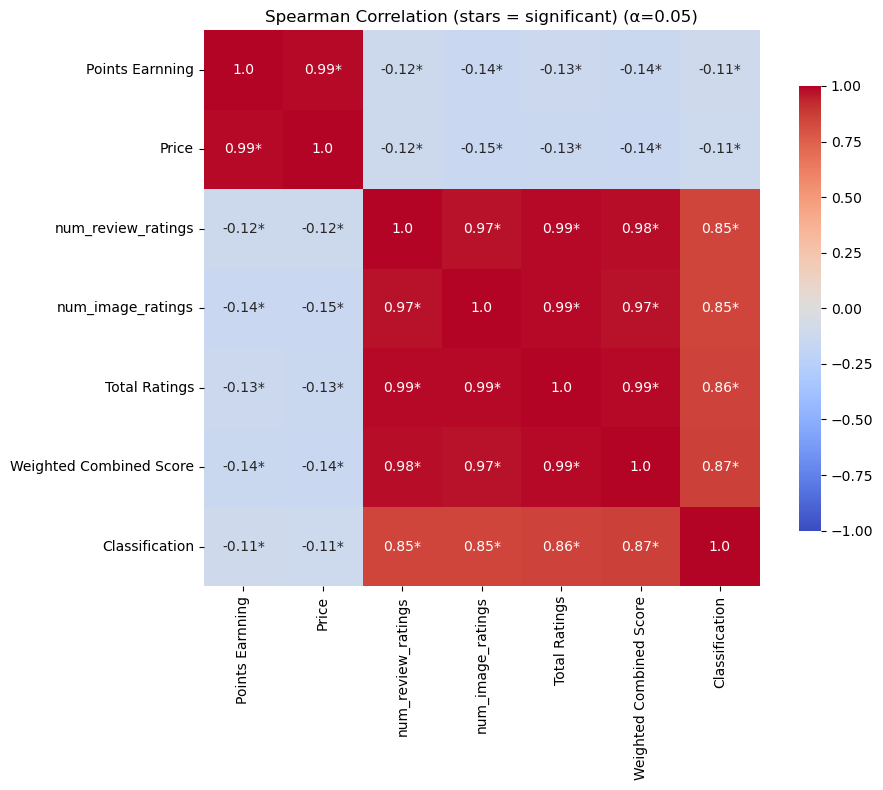

In [22]:
corr_df, pval_df = compute_spearman_corr(copy)

# Option 1: mask non-significant cells
# plot_spearman_heatmap_mask(corr_df, pval_df, alpha=0.05)

# Option 2: keep all cells but mark significant ones with a star
plot_spearman_heatmap_stars(corr_df, pval_df, alpha=0.05)


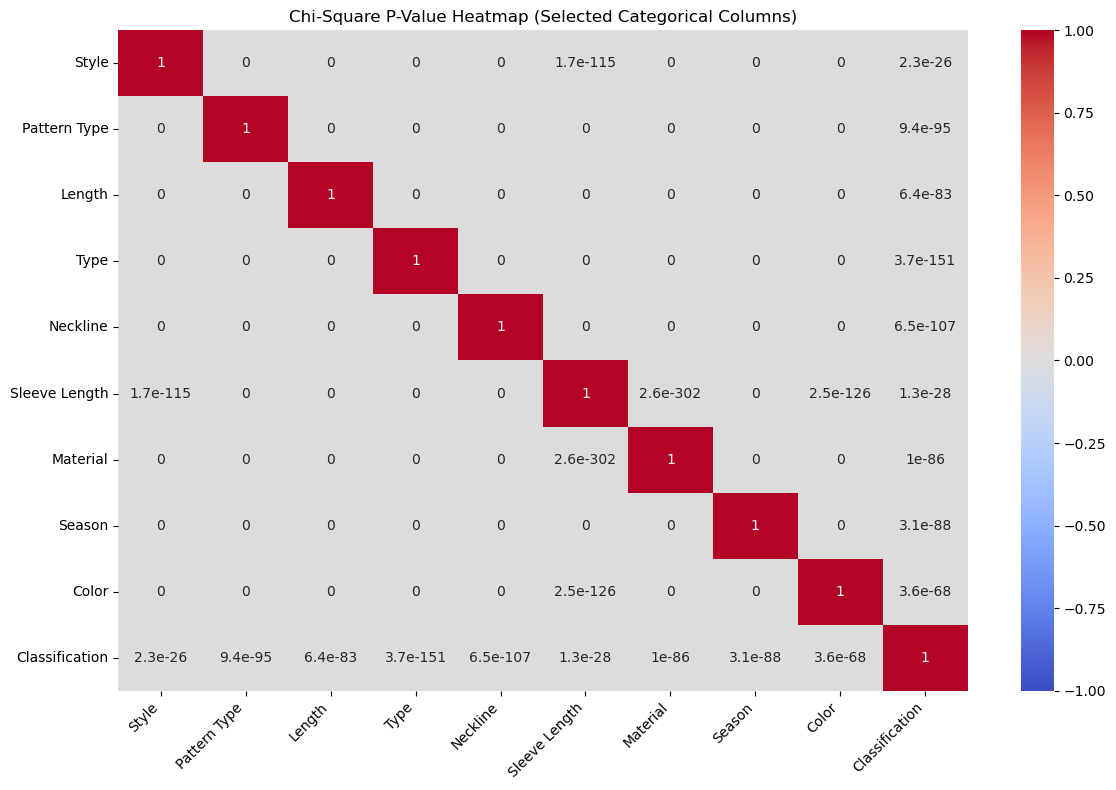

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from itertools import combinations

selected_cat_cols = [
    'Style', 'Pattern Type', 'Length', 'Type', 'Neckline',
    'Sleeve Length', 'Material', 'Season', 'Color', 'Classification'
]

pval_matrix = pd.DataFrame(index=selected_cat_cols, columns=selected_cat_cols)

for col1, col2 in combinations(selected_cat_cols, 2):
    contingency = pd.crosstab(copy[col1], copy[col2])
    try:
        _, p, _, _ = chi2_contingency(contingency)
        pval_matrix.loc[col1, col2] = p
        pval_matrix.loc[col2, col1] = p
    except:
        pval_matrix.loc[col1, col2] = np.nan
        pval_matrix.loc[col2, col1] = np.nan

np.fill_diagonal(pval_matrix.values, 1)

pval_matrix = pval_matrix.astype(float)

# heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pval_matrix, center=0, vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.title("Chi-Square P-Value Heatmap (Selected Categorical Columns)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [24]:
#remove colors with low frequency.
val = copy['Color'].value_counts()
y = val[val < 30].index
copy['Color'] =  copy['Color'].replace({x:'other' for x in y})
copy['Color'].nunique()

#remove style type with low frequency.
val = copy['Style'].value_counts()
y = val[val < 30].index
copy['Style'] =  copy['Style'].replace({x:'other' for x in y})
copy['Style'].nunique()


11

In [25]:
def find_string_cols(df):
    list_cols=[]
    for col in df.columns: 
        if((df[col].dtype=='object') and (col not in ['SKU','Item Name','Details'])):
            list_cols.append(col)
    return list_cols

In [26]:
def encode_string_cols(df,list_cols):
    le = preprocessing.LabelEncoder()

    for col in list_cols:
        df[col].fillna("Empty", inplace=True)
        df[col] = le.fit_transform(df[col])
    return df,le

In [27]:
copy,le=encode_string_cols(copy,find_string_cols(copy))

In [28]:
copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13796 entries, 0 to 13846
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SKU                      13796 non-null  object 
 1   Points Earnning          13796 non-null  int64  
 2   Style                    13796 non-null  int64  
 3   Color                    13796 non-null  int64  
 4   Pattern Type             13796 non-null  int64  
 5   Length                   13796 non-null  int64  
 6   Type                     13796 non-null  int64  
 7   Neckline                 13796 non-null  int64  
 8   Sleeve Length            13796 non-null  int64  
 9   Sleeve Type              13796 non-null  int64  
 10  Placket Type             13796 non-null  int64  
 11  Season                   13796 non-null  int64  
 12  Material                 13796 non-null  int64  
 13  Fabric                   13796 non-null  int64  
 14  Sheer                    13

In [29]:
leakage_features = ["SKU", "num_review_ratings", "Total Ratings", "Weighted Combined Score"]

copy = copy.drop(columns=leakage_features, errors="ignore")

In [30]:
#save results table 
copy.to_csv( "SheinData.csv", index=False, encoding='utf-8-sig')

In [31]:
copy.shape

(13796, 27)

for statistical analysis 

In [32]:
print(copy['Classification'].unique())


[0 1]


In [33]:
copy.columns

Index(['Points Earnning', 'Style', 'Color', 'Pattern Type', 'Length', 'Type',
       'Neckline', 'Sleeve Length', 'Sleeve Type', 'Placket Type', 'Season',
       'Material', 'Fabric', 'Sheer', 'Fit Type', 'Closure Type', 'Waist Line',
       'Body', 'Bottom Type', 'Item Name', 'Price', 'Placket', 'Belt',
       'Hem Shaped', 'Top Type', 'num_image_ratings', 'Classification'],
      dtype='object')